# Attention Visualization For Hierarchical Model

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import warnings
from matplotlib.collections import PatchCollection
import matplotlib as mpl
import matplotlib.gridspec as gridspec
import jieba
import random

warnings.filterwarnings('ignore')
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

%matplotlib inline
%load_ext autoreload
%autoreload 2
torch.__version__

'1.0.1'

In [2]:
# set random seeds to keep the results identical
def setup_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    
def worker_init_fn(worker_id):
    setup_seed(torch.initial_seed() + worker_id)
    
GLOBAL_SEED = 2019
setup_seed(GLOBAL_SEED)

In [3]:
from HAN import HAN

## Load trained models and parameters

In [4]:
os.listdir('model save/')

['Avg-BiLSTM',
 'HAN',
 'Inter-Attention-BiLSTM',
 'Self-Inter-Attention-BiLSTM',
 'Transformer']

In [5]:
os.listdir('model save/HAN')

['Hierarchical-Attention-Networks-on-Douban.pth',
 'Hierarchical-Attention-Networks-on-IMDB.pth',
 'Hierarchical-Attention-Networks-on-Yelp-Full.pth',
 'Hierarchical-Attention-Networks-on-Yelp-Polarity.pth']

In [6]:
model_pth = 'model save/HAN/Hierarchical-Attention-Networks-on-Douban.pth'
model_name = os.path.splitext(os.path.split(model_pth)[-1])[0]

In [7]:
def load_hierarchical_model(path, output_size=1):
    history = torch.load(path)
    parameters = history['parameters']
    model = HAN(hidden_size=parameters['hidden_size'], embedding=parameters['embedding'], method=parameters['att_method'], rnn_dropout=parameters['rnn_dropout'], embedding_dropout=parameters['embedding_dropout'], word_dropout=parameters['word_dropout'], sent_dropout=parameters['sent_dropout'])
    model.load_state_dict(history['best_model'], strict=False)
    model.to(DEVICE)
    return model, history

In [8]:
model, history = load_hierarchical_model(model_pth)

In [9]:
model

HAN(
  (word_encoder): EncoderBiLSTM(
    (embedding): Embedding(39999, 300)
    (embedding_dropout): Dropout(p=0.5)
    (lstm): LSTM(300, 128, batch_first=True, bidirectional=True)
    (rnn_dropout): Dropout(p=0.2)
  )
  (word_attn): Attention(
    (linear): Linear(in_features=512, out_features=256, bias=True)
    (v): Linear(in_features=256, out_features=1, bias=True)
  )
  (word_dropout): Dropout(p=0.2)
  (sent_lstm): LSTM(256, 128, batch_first=True, bidirectional=True)
  (sent_attn): Attention(
    (linear): Linear(in_features=512, out_features=256, bias=True)
    (v): Linear(in_features=256, out_features=1, bias=True)
  )
  (sent_dropout): Dropout(p=0.2)
  (out): Linear(in_features=256, out_features=1, bias=True)
)

## Get the attention layer output by Pytorch hook function

In [10]:
sent_att_weights = []
word_att_weights = []
def hook_word_attention(module, input, output):
    with torch.no_grad():
        global word_att_weights
        word_att_weights.clear()
        word_att_weights.append(output.data.cpu().numpy())
        
def hook_sent_attention(module, input, output):
    with torch.no_grad():
        global sent_att_weights
        sent_att_weights.clear()
        sent_att_weights.append(output.data.cpu().numpy())

In [11]:
try:
    word_handle.remove()
    sent_handle.remove()
except:
    pass
word_handle = model.word_attn.register_forward_hook(hook_word_attention)
sent_handle = model.sent_attn.register_forward_hook(hook_sent_attention)

## Load data for visualization

In [12]:
# df_test = pd.read_csv('dataset_hierarchical/yelp_review_polarity_csv/test.csv', header=None)
# word2num_series = pd.read_hdf('dataset_hierarchical/yelp_review_polarity_csv/word2num_series.h5', key='s')
df_test = pd.read_csv('dataset_hierarchical/Douban/test.csv')
word2num_series = pd.read_hdf('dataset_hierarchical/Douban/word2num_series.h5', key='s')

In [14]:
# df_test.columns = ['label', 'content']
# df_test.label = df_test.label-1

In [15]:
df_test.head()

,name,rating,comment_href,label,content
0,小羊肖恩 Shaun the Sheep Movie,8.4,https://movie.douban.com/subject/24397586/comm...,1,#阿德曼工作室#出品部部经典，粘土动画在3D动画强势市场下已经少有建树，以#小羊肖恩#为我们...
1,忍之国,7.0,https://movie.douban.com/subject/26806780/comm...,0,往死里黑伊贺忍者，结尾平白露骨地把现代人批判一番？无门这个人物的作用是啥？最后的转变似乎根本...
2,偷拐抢骗 Snatch,8.5,https://movie.douban.com/subject/1301171/comme...,1,Fuck-face、流氓、骗子、暴徒、恶棍、打手、蠢蛋、赌徒、抢劫犯、秀逗的美国人、精明的吉普赛人
3,吓死你！,4.8,https://movie.douban.com/subject/3015840/comme...,0,第二个故事里面 多帧画面连续重复出现 我真的有点火大！
4,英国病人 The English Patient,8.5,https://movie.douban.com/subject/1291853/comme...,1,如果分為三段，每段50多分鐘，最後一段最精彩！情緒越漲越高，請千萬要耐著性子看完前面略微平淡...


## Predict single example and visualize attention

In [16]:
from utils import process, process_zh, sent_split, sent_split_zh, clean_text, clean_text_zh, transform_punc

In [17]:
def predict_single_example(model, text, zh=False):
    if zh:
        #df_words = pd.DataFrame(list(jieba.cut(text)), columns=['raw_word'])
        #df_words['clean_word'] = df_words['raw_word']
        sentences = sent_split_zh(text)
        res = []
        idx = 0
        for sent in sentences:
            split_sen = list(jieba.cut(sent))
            df_sent = pd.DataFrame(split_sen, columns=['raw_word'])
            if len(split_sen) > 0:
                df_sent['sent_id'] = idx
                res.append(df_sent)
                idx += 1
        df_processed_words = pd.concat(res).reset_index(drop=True)
        df_processed_words['clean_word'] = df_processed_words['raw_word'].apply(clean_text_zh).str.replace(r'\s+', '')
        df_processed_words['word_id'] = df_processed_words['clean_word'].apply(lambda x: word2num_series.get(x, None))
    else:
        df_words = transform_punc(text)
        sentences = sent_split(df_words)
        res = []
        idx = 0
        for sent in sentences:
            split_sen = sent.split()
            df_sent = pd.DataFrame(split_sen, columns=['raw_word'])
            if len(split_sen) > 0:
                df_sent['sent_id'] = idx
                res.append(df_sent)
                idx += 1
        df_processed_words = pd.concat(res).reset_index(drop=True)
        df_processed_words['clean_word'] = df_processed_words['raw_word'].apply(clean_text).str.replace(r'\s+', '')
        df_processed_words['word_id'] = df_processed_words['clean_word'].apply(lambda x: word2num_series.get(x, None))
    inputs = []
    for i in range(max(df_processed_words['sent_id'])+1):
        inputs.append(list(df_processed_words[df_processed_words['sent_id']==i]['word_id'].dropna().astype(int)))
        
    max_sen_len = max([len(sen) for sen in inputs])
    X = torch.zeros(1, len(inputs), max_sen_len, dtype=torch.int64)
    for idx, sen in enumerate(inputs):
        X[0, idx, :len(sen)] = torch.tensor(sen, dtype=torch.int64)
    model.eval()
    with torch.no_grad():
        predict = model(X.to(DEVICE))
    word_att = word_att_weights[0]
    sent_att = sent_att_weights[0]
    df_processed_words['word_att_weight'] = pd.Series(word_att[word_att>0], index=df_processed_words[df_processed_words['word_id'].notna()].index)
    df_processed_words['sent_att_weight'] = df_processed_words['sent_id'].map(pd.Series(sent_att_weights[0].flatten()))
    df_processed_words['normalized_word_weight'] = np.sqrt(df_processed_words.sent_att_weight) * df_processed_words.word_att_weight
    df_processed_words.fillna(0, inplace=True)
    return F.sigmoid(predict).item(), df_processed_words

In [18]:
def plot_attention(attention_df, predict, context_series, figsize=(10, 6), dpi=150, word_space=0.03, line_space=0.08, margin=0.15, top=0.8, colorbar=True, colorbar_height=20, colorbar_pos = 80, colorbar_width=10, save=False, model_name=None, index=None, zh=False):
    
    fig = plt.figure(figsize=figsize, dpi=150)
    gspec = gridspec.GridSpec(100, 100)

    start_x, start_y = margin, top
    pos_x, pos_y = start_x, start_y
    line_length = 1-start_x
    width = 0

    # add colorBar
    colorBarAx = plt.subplot(gspec[colorbar_pos:colorbar_pos+colorbar_height, colorbar_width:-colorbar_width], frameon=False)
    cmap = mpl.cm.Reds
    norm = mpl.colors.Normalize(vmin=0, vmax=1)
    cb1 = mpl.colorbar.ColorbarBase(colorBarAx, cmap=cmap,
                                    norm=norm,
                                    orientation='horizontal')
    
    cmap = mpl.cm.Blues
    norm = mpl.colors.Normalize(vmin=0, vmax=1)
    cb2 = mpl.colorbar.ColorbarBase(colorBarAx, cmap=cmap,
                                    norm=norm,
                                    orientation='horizontal')
    cb2.remove()
    if not colorbar:
        cb1.remove()
    cb1.set_label('Weights(Normalized)')
    
    ax = plt.subplot(gspec[:colorbar_pos, :], frameon=False)
    font = 'simHei' if zh else ''
    pre_line = -1
    for i in range(len(attention_df)):
        if attention_df['sent_id'].iloc[i] != pre_line:
            pre_line = attention_df['sent_id'][i]
            att_weights = attention_df.iloc[i]['sent_att_weight']
            if i != 0:
                pos_x = start_x
                pos_y = pos_y - line_space
            norm = mpl.colors.Normalize(vmin=min(attention_df['sent_att_weight']), vmax=max(attention_df['sent_att_weight']))
            cb2.set_norm(norm)
            textbox = fig.text(pos_x, pos_y, '  {}  '.format(pre_line+1), fontproperties=font,size=10, rotation=0,
             ha="left", va="center", transform=fig.transFigure,
             bbox=dict(boxstyle="round,pad=0.3",
                       ec=cb2.to_rgba(att_weights)[:3],
                       fc=cb2.to_rgba(att_weights)[:3],
                       alpha=0.7,
                       )
             )
            textbox.update_bbox_position_size(fig.canvas.get_renderer())
            width = textbox.get_bbox_patch().get_width()
            width = fig.transFigure.inverted().transform((width, 0))[0]
            pos_x = pos_x + width + 2*word_space
        elif pos_x > line_length:
            pos_x = start_x
            pos_y = pos_y - line_space
            textbox = fig.text(pos_x, pos_y, '      ', fontproperties=font,size=10, rotation=0,
             ha="left", va="center", transform=fig.transFigure,
             bbox=dict(boxstyle="round,pad=0.3",
                       ec=cb2.to_rgba(att_weights)[:3],
                       fc=cb2.to_rgba(att_weights)[:3],
                       alpha=0,
                       )
             )
            textbox.update_bbox_position_size(fig.canvas.get_renderer())
            width = textbox.get_bbox_patch().get_width()
            width = fig.transFigure.inverted().transform((width, 0))[0]
            pos_x = pos_x + width + word_space
            
        word = attention_df['raw_word'][i]
        att_weights = attention_df['normalized_word_weight'][i]
        norm = mpl.colors.Normalize(vmin=min(attention_df['normalized_word_weight']), vmax=max(attention_df['normalized_word_weight']))
        cb1.set_norm(norm)
        textbox = fig.text(pos_x, pos_y, word, fontproperties=font,size=10, rotation=0,
             ha="left", va="center", transform=fig.transFigure,
             bbox=dict(boxstyle="round,pad=0.3",
                       ec=cb1.to_rgba(att_weights)[:3],
                       fc=cb1.to_rgba(att_weights)[:3],
                       alpha=0.6,
                       )
             )
        textbox.update_bbox_position_size(fig.canvas.get_renderer())
        width = textbox.get_bbox_patch().get_width()
        width = fig.transFigure.inverted().transform((width, 0))[0]
        pos_x = pos_x + width + word_space
        pos_y = pos_y       
        
    plt.setp(plt.gca(), frame_on=False, xticks=(), yticks=())
    if zh:
        plt.title("Model Name:  {}\nMovie Name:  {}\nTrue Label:  {}\nPredict:     {:.4f}".format(model_name, context_series['name'], context_series['label'], predict),loc='left', fontproperties=font, fontsize=12)
    else:
        plt.title("Model Name:  {}\nTrue Label:     {}\nPredict:        {:.4f}".format(model_name, context_series['label'], predict),loc='left', fontproperties=font, fontsize=10)
    plt.tight_layout()
    if save:
        plt.savefig('attention visualization/{}-{}.png'.format(model_name, index))

In [19]:
if not os.path.exists('attention visualization'):
    os.mkdir('attention visualization')

## HAN examples on douban

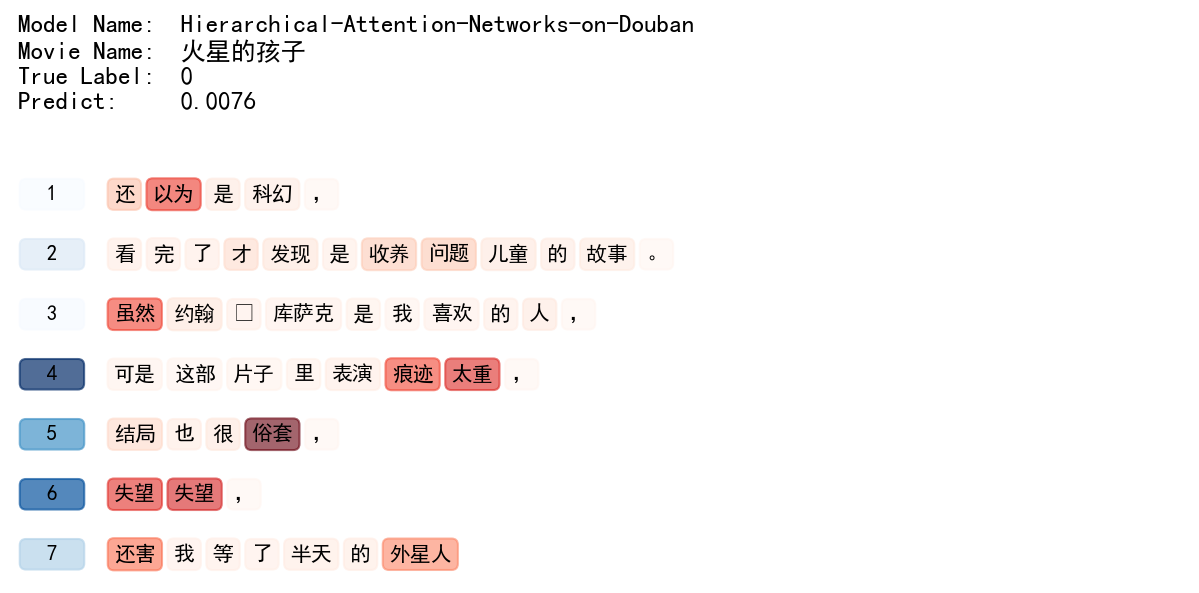

In [23]:
index = 38
predict, attention_df = predict_single_example(model, df_test['content'][index], zh=True)
plot_attention(attention_df, predict, context_series=df_test.iloc[index], figsize=(10, 8), dpi=300, word_space=0.012, line_space=0.05, margin=0.13, top=0.82,  colorbar=True, colorbar_height=3, colorbar_pos=50, colorbar_width=1, save=True, model_name=model_name, index=index, zh=True)

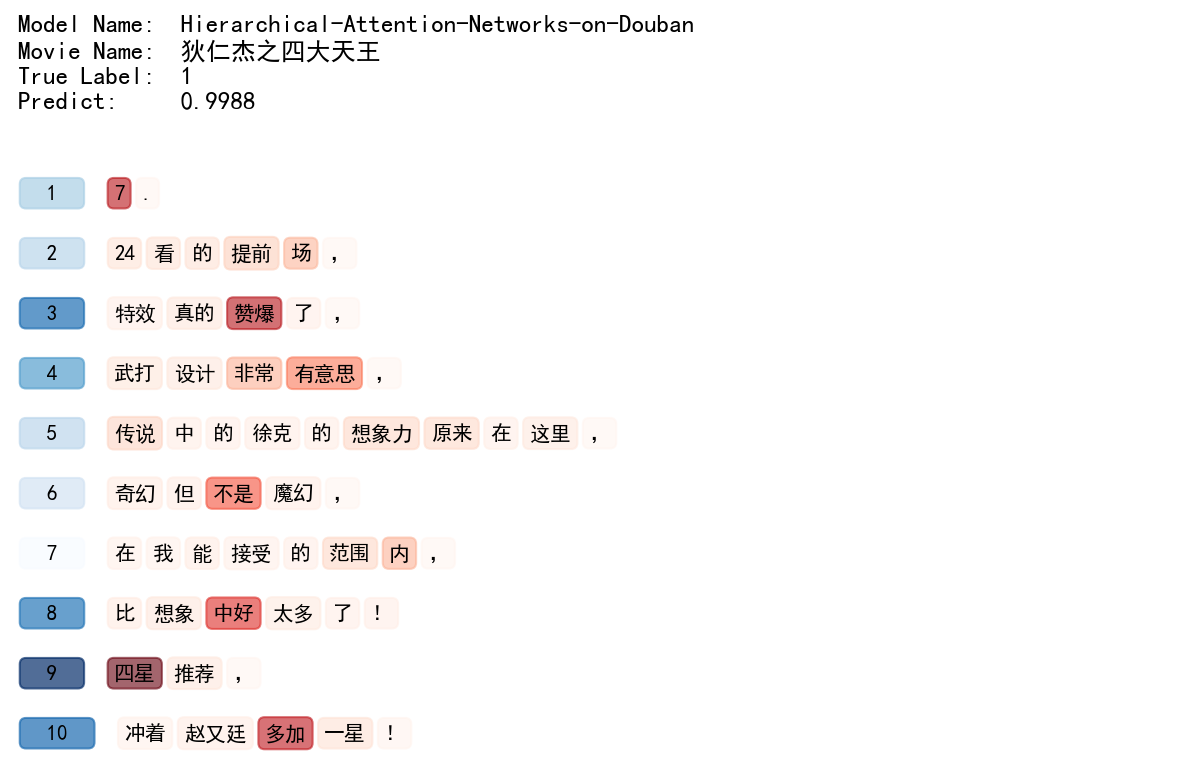

In [24]:
index = 46
predict, attention_df = predict_single_example(model, df_test['content'][index], zh=True)
plot_attention(attention_df, predict, context_series=df_test.iloc[index], figsize=(10, 8), dpi=300, word_space=0.012, line_space=0.05, margin=0.13, top=0.82,  colorbar=True, colorbar_height=3, colorbar_pos=50, colorbar_width=1, save=True, model_name=model_name, index=index, zh=True)

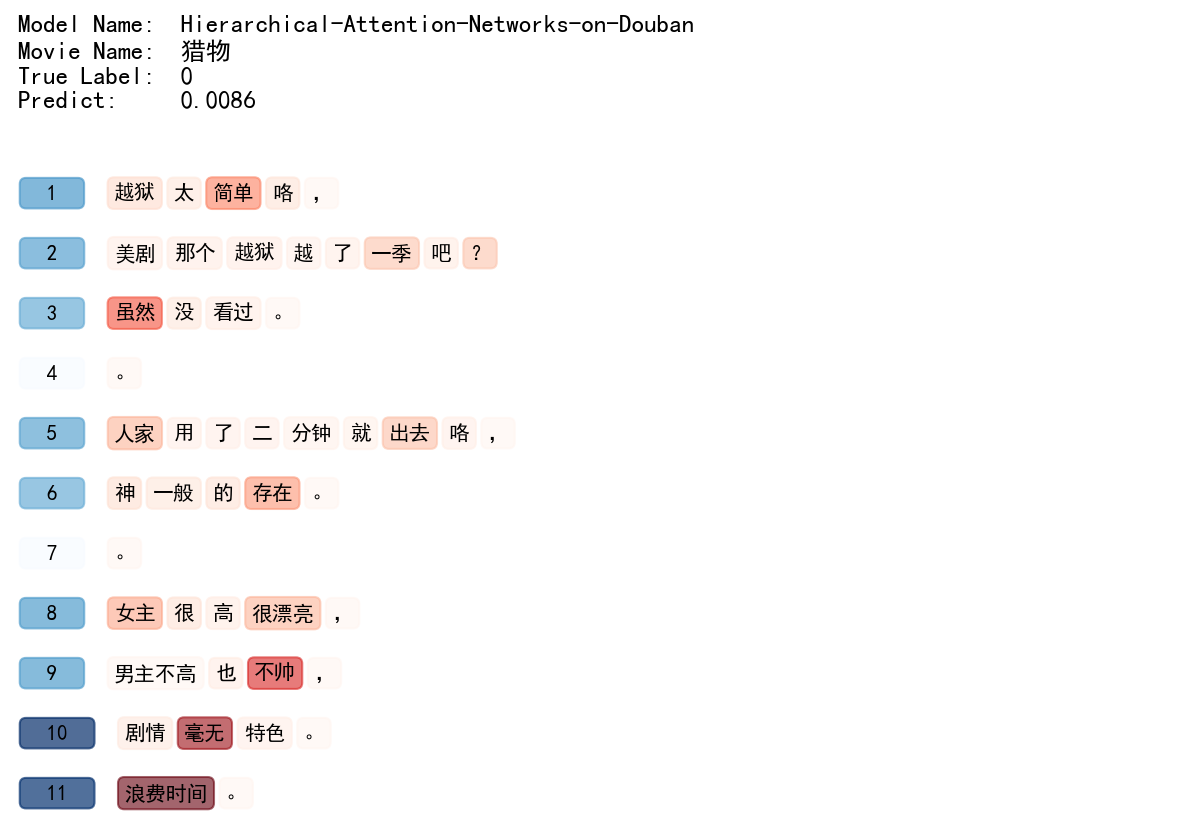

In [25]:
index = 48
predict, attention_df = predict_single_example(model, df_test['content'][index], zh=True)
plot_attention(attention_df, predict, context_series=df_test.iloc[index], figsize=(10, 8), dpi=300, word_space=0.012, line_space=0.05, margin=0.13, top=0.82,  colorbar=True, colorbar_height=3, colorbar_pos=50, colorbar_width=1, save=True, model_name=model_name, index=index, zh=True)

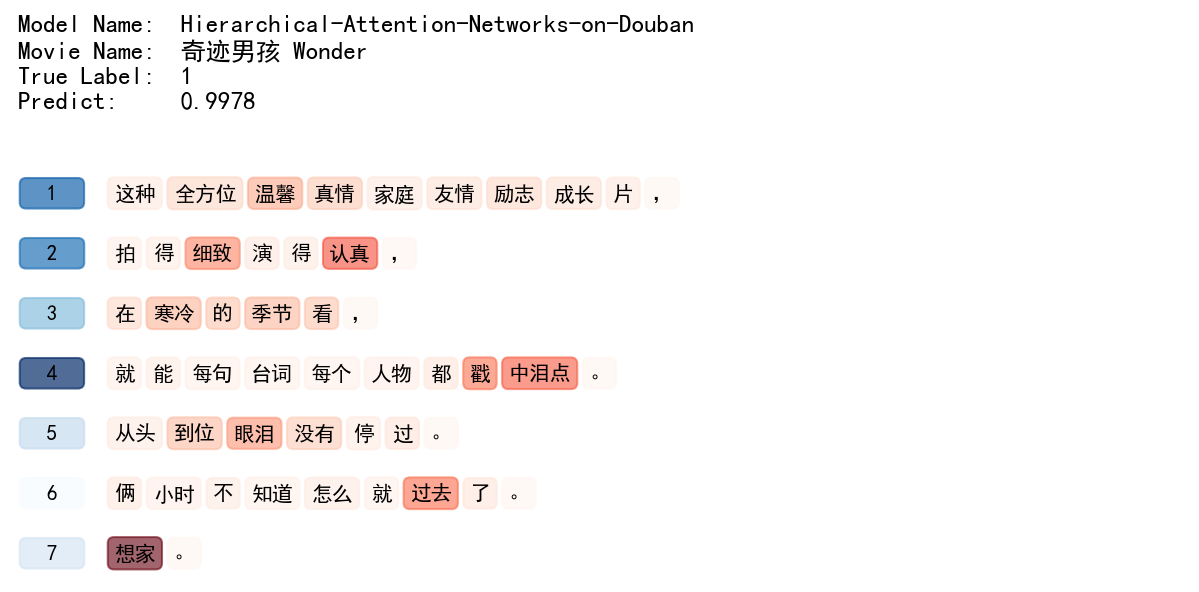

In [26]:
index = 67
predict, attention_df = predict_single_example(model, df_test['content'][index], zh=True)
plot_attention(attention_df, predict, context_series=df_test.iloc[index], figsize=(10, 8), dpi=300, word_space=0.012, line_space=0.05, margin=0.13, top=0.82,  colorbar=True, colorbar_height=3, colorbar_pos=50, colorbar_width=1, save=True, model_name=model_name, index=index, zh=True)

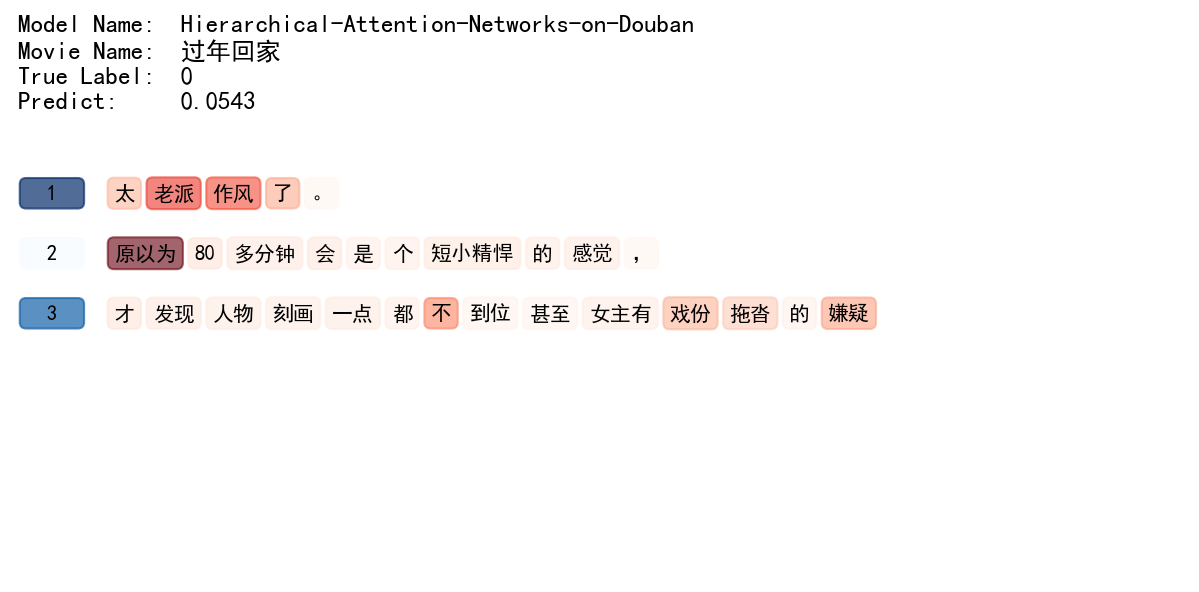

In [27]:
index = 51130
predict, attention_df = predict_single_example(model, df_test['content'][index], zh=True)
plot_attention(attention_df, predict, context_series=df_test.iloc[index], figsize=(10, 8), dpi=300, word_space=0.012, line_space=0.05, margin=0.13, top=0.82,  colorbar=True, colorbar_height=3, colorbar_pos=50, colorbar_width=1, save=True, model_name=model_name, index=index, zh=True)

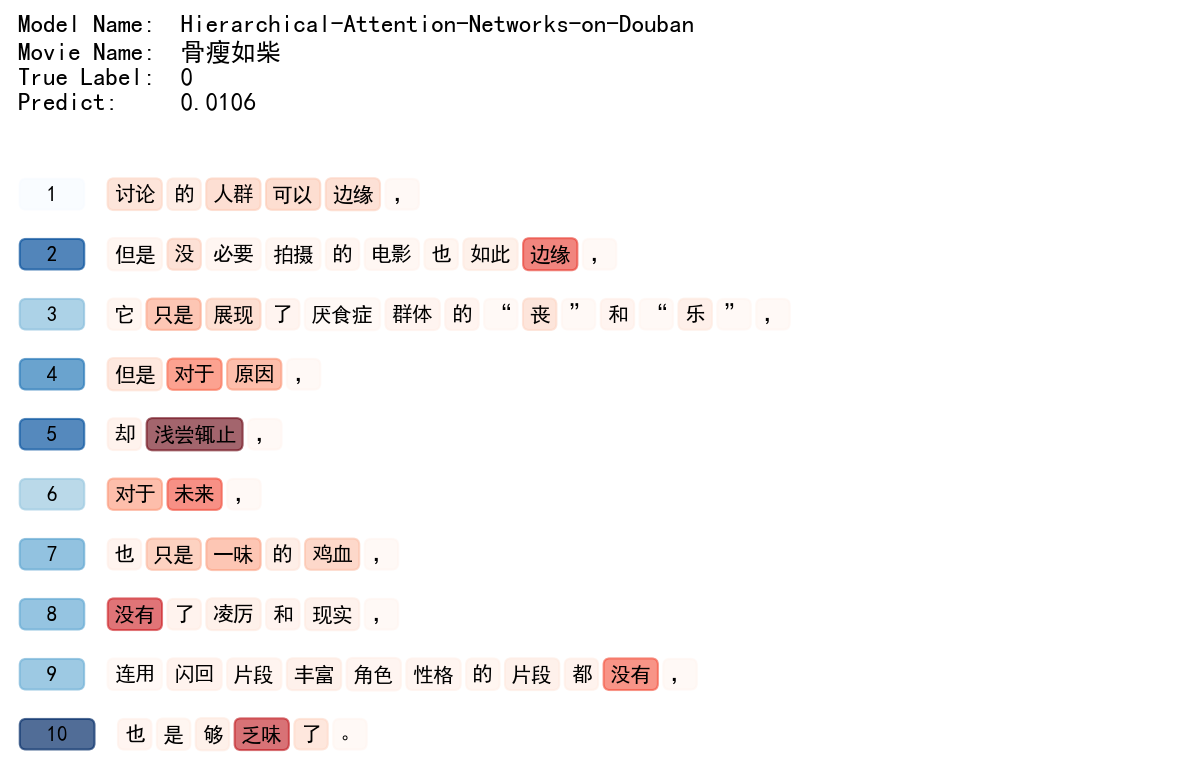

In [28]:
index = 51153
predict, attention_df = predict_single_example(model, df_test['content'][index], zh=True)
plot_attention(attention_df, predict, context_series=df_test.iloc[index], figsize=(10, 8), dpi=300, word_space=0.012, line_space=0.05, margin=0.13, top=0.82,  colorbar=True, colorbar_height=3, colorbar_pos=50, colorbar_width=1, save=True, model_name=model_name, index=index, zh=True)

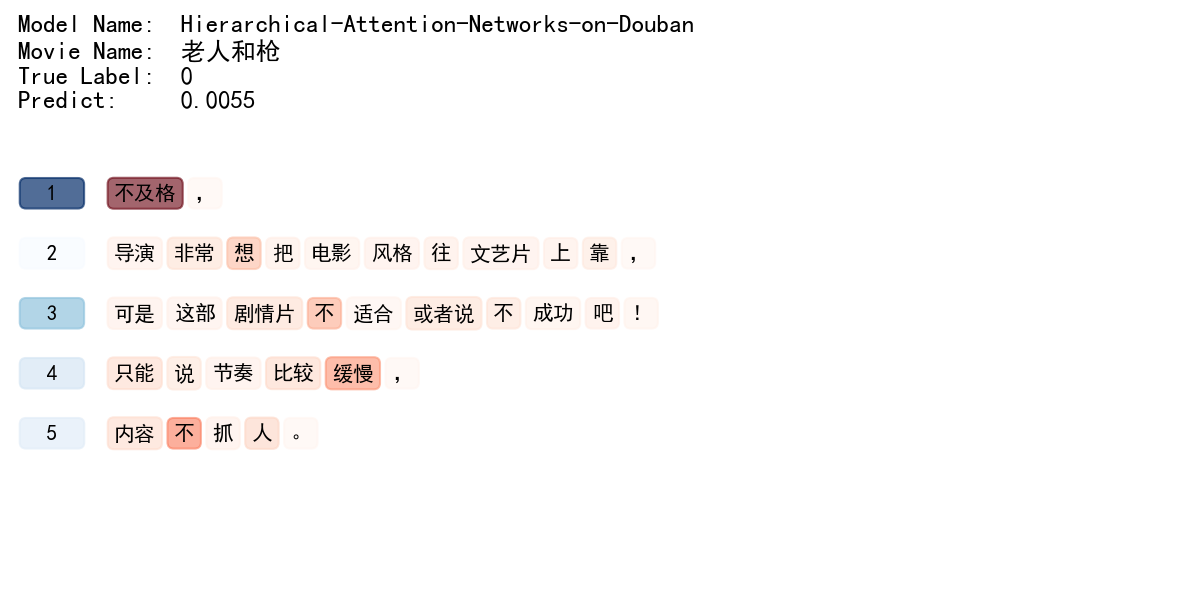

In [29]:
index = 51306
predict, attention_df = predict_single_example(model, df_test['content'][index], zh=True)
plot_attention(attention_df, predict, context_series=df_test.iloc[index], figsize=(10, 8), dpi=300, word_space=0.012, line_space=0.05, margin=0.13, top=0.82,  colorbar=True, colorbar_height=3, colorbar_pos=50, colorbar_width=1, save=True, model_name=model_name, index=index, zh=True)

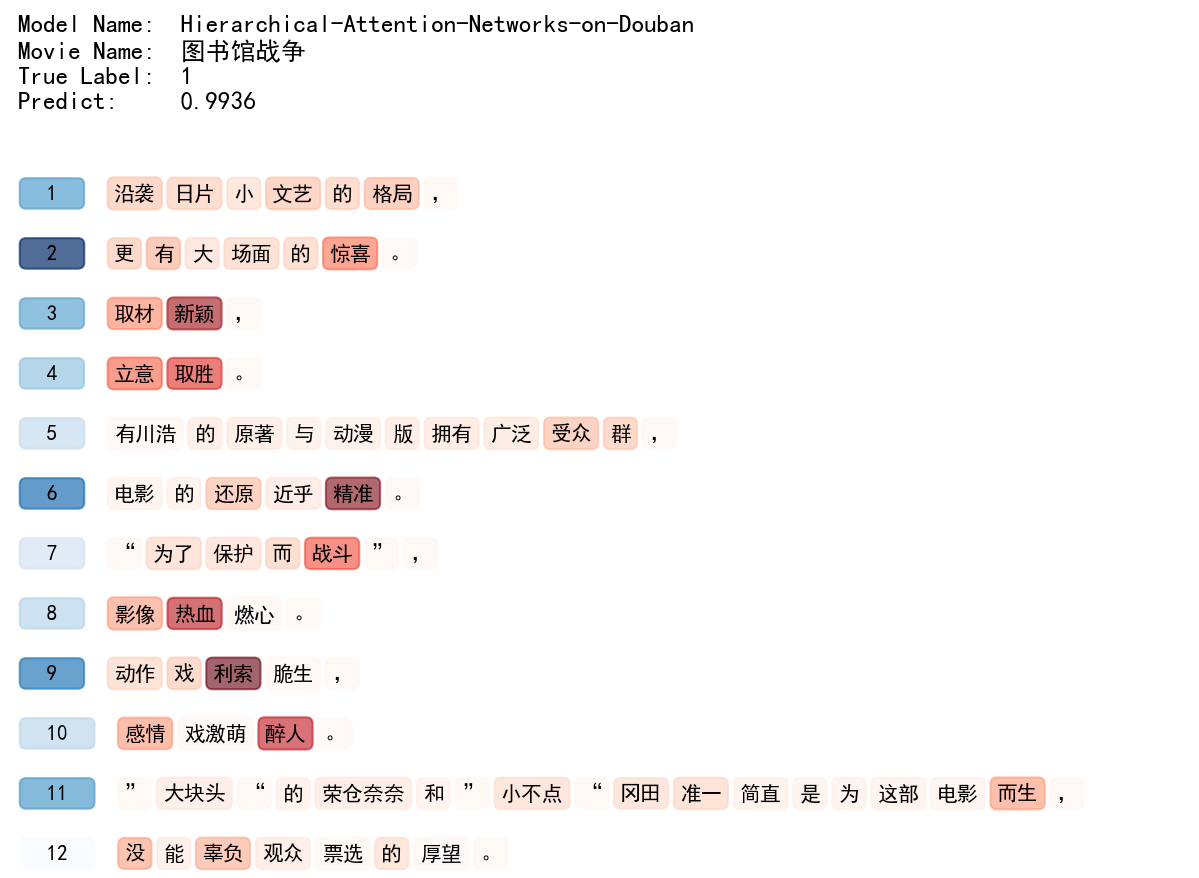

In [30]:
index = 90000
predict, attention_df = predict_single_example(model, df_test['content'][index], zh=True)
plot_attention(attention_df, predict, context_series=df_test.iloc[index], figsize=(10, 8), dpi=300, word_space=0.012, line_space=0.05, margin=0.13, top=0.82,  colorbar=True, colorbar_height=3, colorbar_pos=50, colorbar_width=1, save=True, model_name=model_name, index=index, zh=True)

## HAN examples on Yelp Polarity dataset

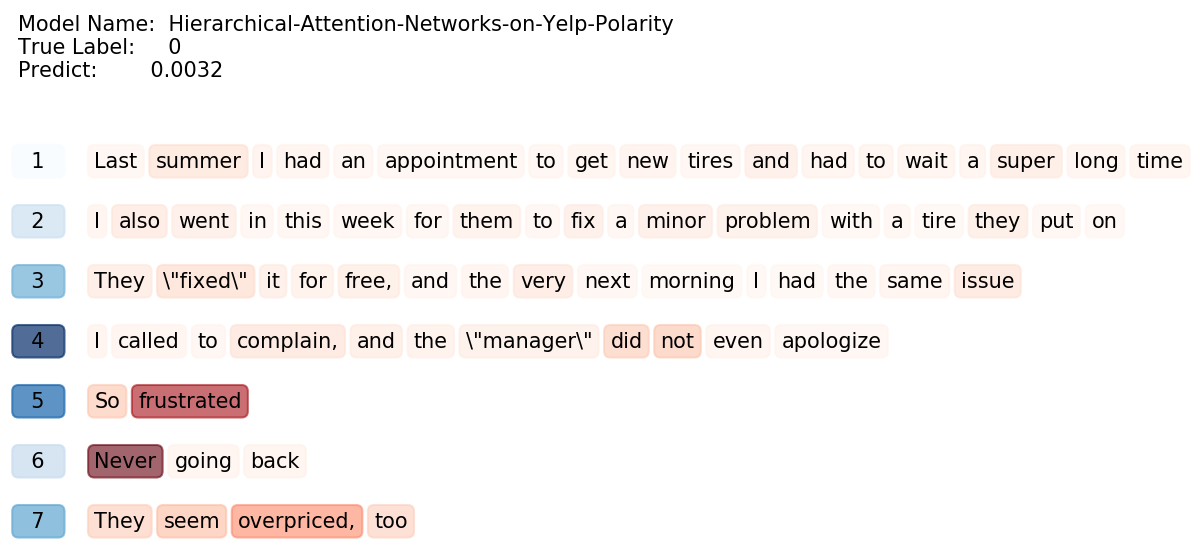

In [141]:
index = 1
predict, attention_df = predict_single_example(model, df_test['content'][index], zh=False)
plot_attention(attention_df, predict, context_series=df_test.iloc[index], figsize=(10, 8), dpi=300, word_space=0.012, line_space=0.05, margin=0.125, top=0.82,  colorbar=True, colorbar_height=3, colorbar_pos=50, colorbar_width=1, save=True, model_name=model_name, index=index, zh=False)

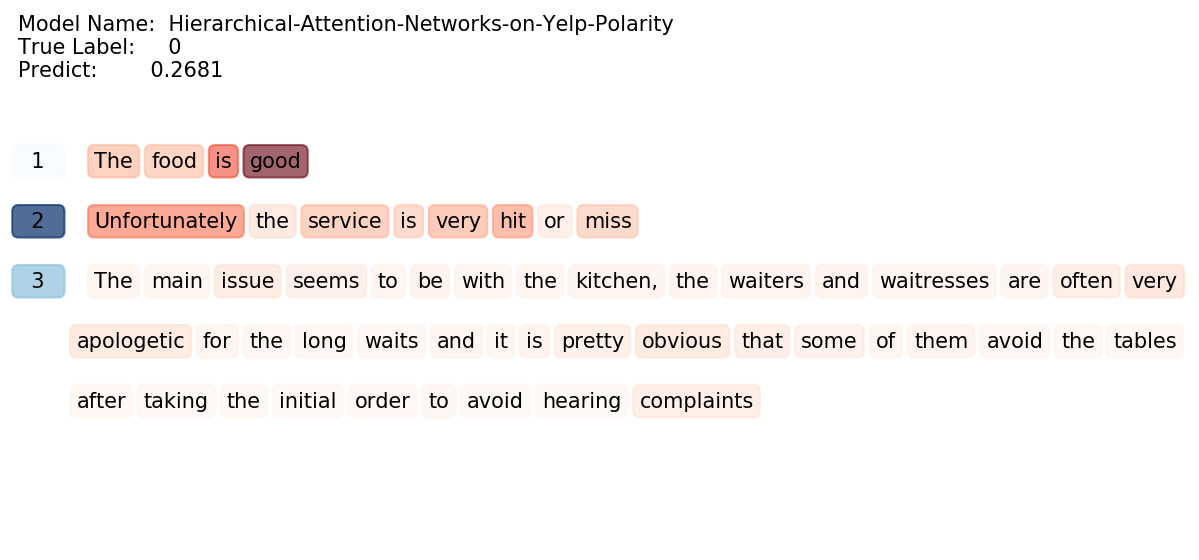

In [142]:
index = 3
predict, attention_df = predict_single_example(model, df_test['content'][index], zh=False)
plot_attention(attention_df, predict, context_series=df_test.iloc[index], figsize=(10, 8), dpi=300, word_space=0.012, line_space=0.05, margin=0.125, top=0.82,  colorbar=True, colorbar_height=3, colorbar_pos=50, colorbar_width=1, save=True, model_name=model_name, index=index, zh=False)

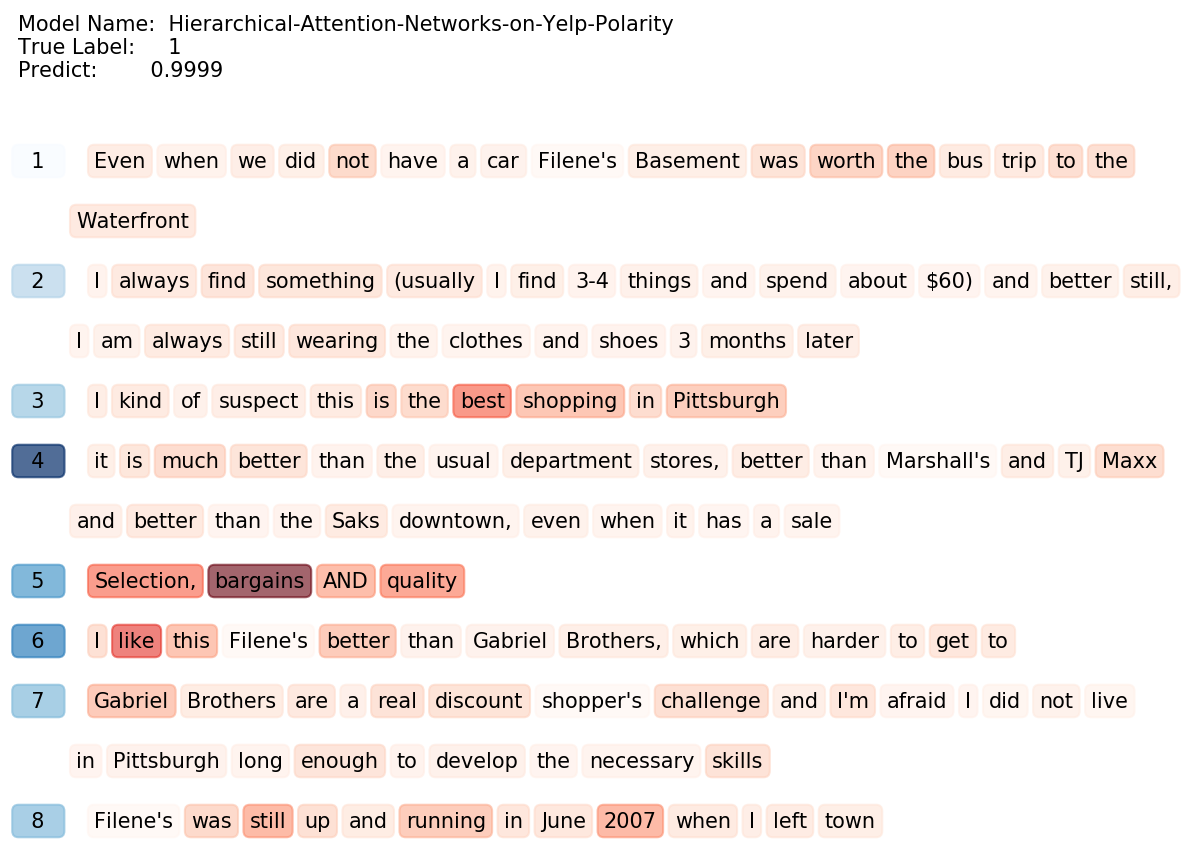

In [143]:
index = 4
predict, attention_df = predict_single_example(model, df_test['content'][index], zh=False)
plot_attention(attention_df, predict, context_series=df_test.iloc[index], figsize=(10, 8), dpi=300, word_space=0.012, line_space=0.05, margin=0.125, top=0.82,  colorbar=True, colorbar_height=3, colorbar_pos=50, colorbar_width=1, save=True, model_name=model_name, index=index, zh=False)

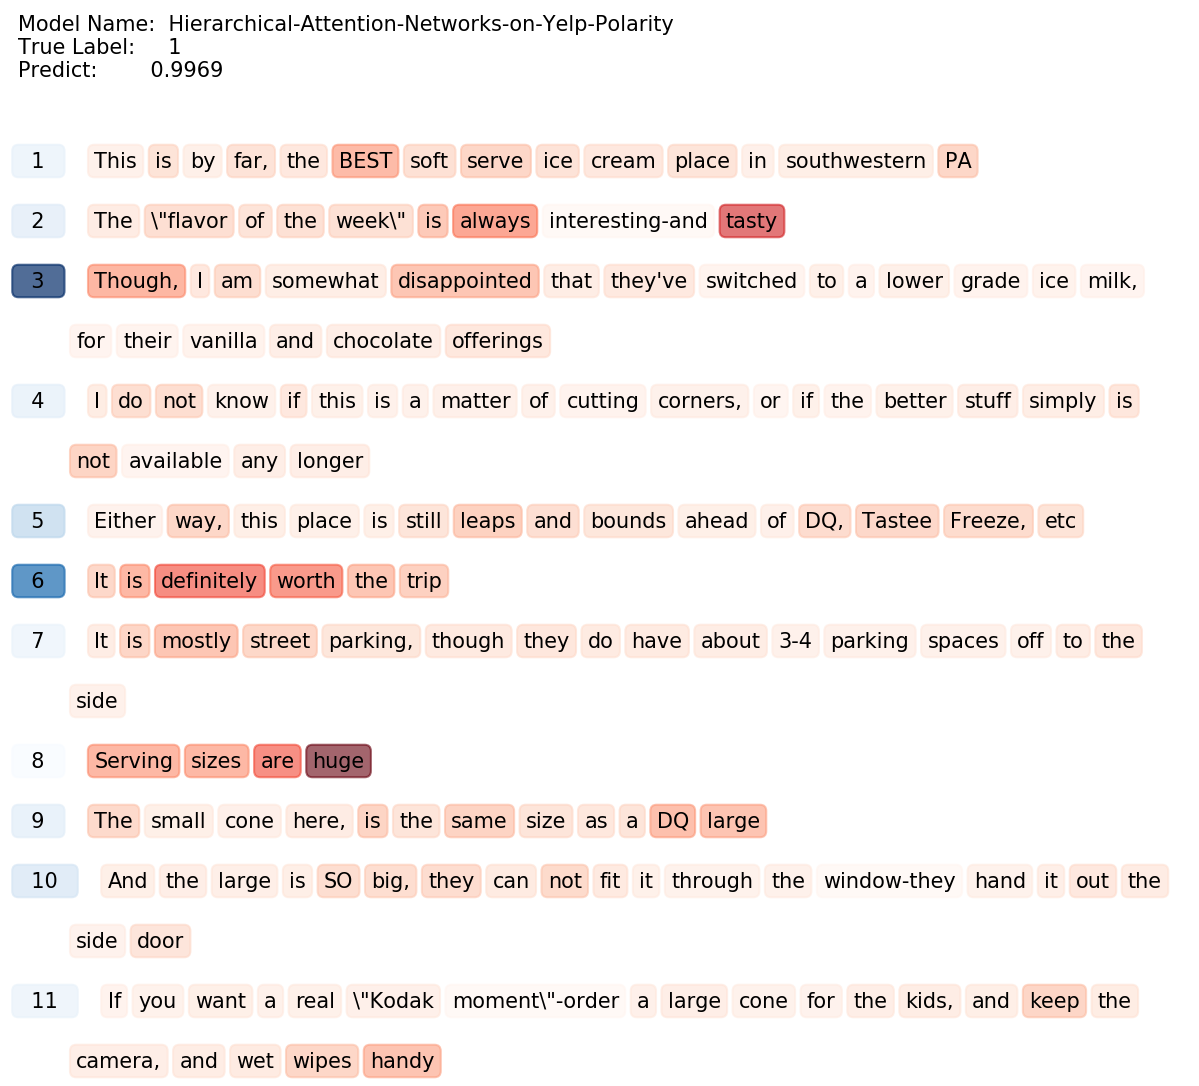

In [144]:
index = 20
predict, attention_df = predict_single_example(model, df_test['content'][index], zh=False)
plot_attention(attention_df, predict, context_series=df_test.iloc[index], figsize=(10, 8), dpi=300, word_space=0.012, line_space=0.05, margin=0.125, top=0.82,  colorbar=True, colorbar_height=3, colorbar_pos=50, colorbar_width=1, save=True, model_name=model_name, index=index, zh=False)

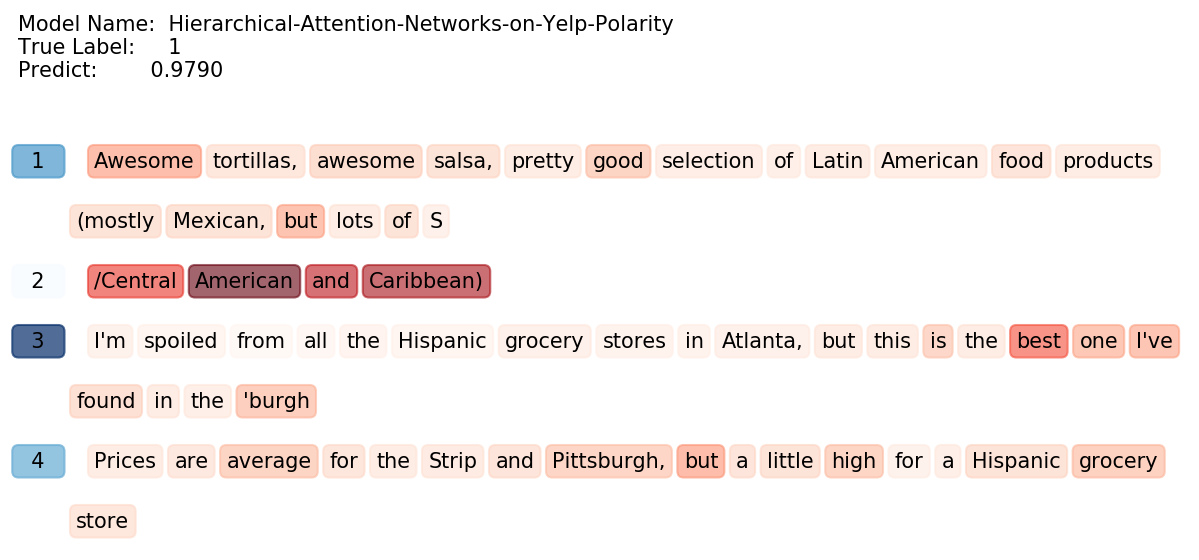

In [145]:
index = 100
predict, attention_df = predict_single_example(model, df_test['content'][index], zh=False)
plot_attention(attention_df, predict, context_series=df_test.iloc[index], figsize=(10, 8), dpi=300, word_space=0.012, line_space=0.05, margin=0.125, top=0.82,  colorbar=True, colorbar_height=3, colorbar_pos=50, colorbar_width=1, save=True, model_name=model_name, index=index, zh=False)